In [1]:
NUM_TRUE_FACTORS = 32
NUM_ESTIMATED_FACTORS = 512

# setup

In [2]:
import math
import torch
from torch import nn
import torch.nn.functional as F
import dct
from tqdm import tqdm
import math
from torch import vmap

torch.set_default_device("cuda")
torch.manual_seed(325)

In [3]:
class ExpMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.device = "cuda"
        self.fc = nn.Linear(input_dim, hidden_dim, bias=False)
        with torch.no_grad():
            self.fc.weight.data = F.normalize(self.fc.weight.data, dim=1)
        self.activation = torch.expm1
        self.out = nn.Linear(hidden_dim, output_dim, bias=False)
        with torch.no_grad():
            self.out.weight.data = F.normalize(self.out.weight.data, dim=0)

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        x = self.out(x)
        return x

In [4]:
f = ExpMLP(4096, 4096, NUM_TRUE_FACTORS)

In [5]:
X = torch.zeros(1, 1, 4096)
Y = torch.zeros(1, 1, 4096)

In [6]:
delta_acts_single = lambda x, X, Y: f(x).unsqueeze(0)
delta_acts_single.device = "cuda"
delta_acts = vmap(
    delta_acts_single, in_dims=(1, None, None), out_dims=2, chunk_size=512
)

# jacobian init, $\tau=10$ -> MMCS of $.85$

In [7]:
%%time
exp_dct = dct.ExponentialDCT(num_factors=NUM_ESTIMATED_FACTORS)
U, V = exp_dct.fit(
    delta_acts_single,
    X,
    Y,
    init="jacobian",
    d_proj=32,
    input_scale=1.0,
    max_iters=10,
    beta=1.0,
)

computing jacobian...


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1720538456841/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


computing SVD of jacobian...
computing output directions...


100%|██████████| 1/1 [00:00<00:00, 150.89it/s]


training...


100%|██████████| 1/1 [00:00<00:00, 18.45it/s]

100%|██████████| 1/1 [00:00<00:00, 16.87it/s]

100%|██████████| 1/1 [00:00<00:00, 16.73it/s]

100%|██████████| 1/1 [00:00<00:00, 16.72it/s]

100%|██████████| 10/10 [00:00<00:00, 12.52it/s]

CPU times: user 922 ms, sys: 102 ms, total: 1.02 s
Wall time: 1.06 s


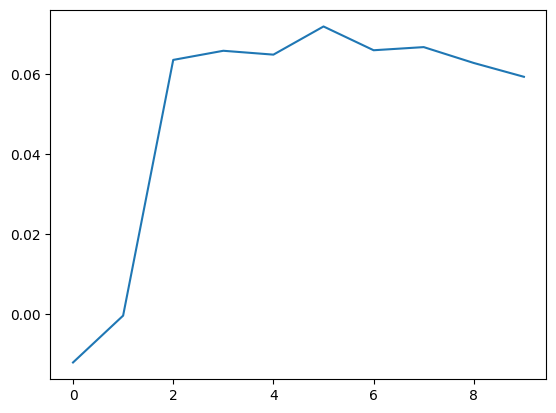

In [8]:
from matplotlib import pyplot as plt

plt.plot(exp_dct.objective_values)

In [9]:
with torch.no_grad():
    sim = f.fc.weight.data @ exp_dct.V
recovery_rate = (sim.max(1).values > 0.99).sum() / NUM_TRUE_FACTORS
mmcs = sim.max(1).values.mean().item()
print(f"recovery rate (>.99 similarity): {recovery_rate:.2f}")
print(f"mmcs: {mmcs:.2f}")

recovery rate (>.99 similarity): 0.25
mmcs: 0.85


# random init, $\tau=100$ iterations -> MMCS of $.99$

In [10]:
%%time
exp_dct = dct.ExponentialDCT(num_factors=NUM_ESTIMATED_FACTORS)
U, V = exp_dct.fit(
    delta_acts_single,
    X,
    Y,
    init="random",
    d_proj=32,
    input_scale=1.0,
    max_iters=100,
    beta=1.0,
)

initializing V,U...
training...


100%|██████████| 1/1 [00:00<00:00, 16.38it/s]

100%|██████████| 1/1 [00:00<00:00, 16.46it/s]

100%|██████████| 1/1 [00:00<00:00, 17.20it/s]

100%|██████████| 1/1 [00:00<00:00, 17.28it/s]

100%|██████████| 1/1 [00:00<00:00, 16.59it/s]

100%|██████████| 1/1 [00:00<00:00, 17.66it/s]

100%|██████████| 1/1 [00:00<00:00, 16.81it/s]

100%|██████████| 1/1 [00:00<00:00, 16.76it/s]

100%|██████████| 1/1 [00:00<00:00, 16.94it/s]

100%|██████████| 1/1 [00:00<00:00, 17.38it/s]

100%|██████████| 1/1 [00:00<00:00, 17.20it/s]

100%|██████████| 1/1 [00:00<00:00, 17.46it/s]

100%|██████████| 1/1 [00:00<00:00, 17.48it/s]

100%|██████████| 1/1 [00:00<00:00, 17.44it/s]

100%|██████████| 1/1 [00:00<00:00, 17.64it/s]

100%|██████████| 1/1 [00:00<00:00, 17.51it/s]

100%|██████████| 1/1 [00:00<00:00, 17.51it/s]

100%|██████████| 1/1 [00:00<00:00, 17.41it/s]

100%|██████████| 1/1 [00:00<00:00, 17.52it/s]

100%|██████████| 1/1 [00:00<00:00, 15.97it/s]

100%|██████████| 1/1 [00:00<00:00, 17.38it/s]

100%|████████

CPU times: user 6.77 s, sys: 291 ms, total: 7.07 s
Wall time: 6.63 s


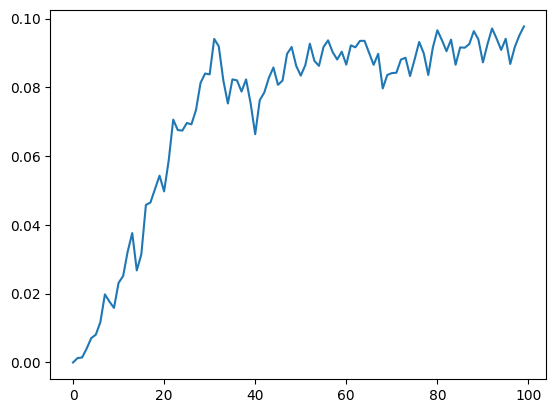

In [11]:
from matplotlib import pyplot as plt

plt.plot(exp_dct.objective_values)

In [12]:
with torch.no_grad():
    sim = f.fc.weight.data @ exp_dct.V
recovery_rate = (sim.max(1).values > 0.99).sum() / NUM_TRUE_FACTORS
mmcs = sim.max(1).values.mean().item()
print(f"recovery rate (>.99 similarity): {recovery_rate:.2f}")
print(f"mmcs: {mmcs:.2f}")

recovery rate (>.99 similarity): 0.84
mmcs: 0.99


# conclusion

We can get >.99 maximum-mean-cosine-similarity (MMCS) recovery in a synthetic setting (for the "easy" case of $m^*=32$) if we deviate slightly from hyper-parameters used in practice. The main difference is that this seems to require a *random* initialization of $\hat U, \hat V$, rather than the projected Jacobian initialization (even though qualitatively this seems to deliver *worse* results on real LLMs). Furthermore, it appears we need more iterations to guarantee perfect recovery ($\tau=100$ in the above run, vs $\tau=10$ in the real-life experiments).

If we do something closer to practice, then we only get an MMCS of $.85$ (although we at least recover $25\%$ of the true source-layer features exactly, i.e. with similarity $>.99$).

In future work, it would be useful to understand:
1. what distribution of synthetic data most closely matches what we expect to see in real-life transformers
2. whether iterating algorithmically on the synthetic setting in 1) can get us better performance "in the wild".
